## Import Library:

In [1]:
import os # untuk berinteraksi dengan sistem operasi, seperti untuk mengakses file dan direktori
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # untuk membagi dataset menjadi subset training dan testing
import torch # Library utama PyTorch untuk komputasi tensor dan deep learning
from torch.utils.data import Dataset, DataLoader # Kelas untuk memanipulasi dataset dan membuat batch data untuk training
from torchvision import transforms # Modul untuk melakukan transformasi pada gambar seperti augmentasi data
import torch.nn as nn # Modul yang berisi berbagai komponen neural network seperti lapisan (layers), fungsi aktivasi, dll
import torch.optim as optim # Modul untuk algoritma optimasi, seperti SGD, Adam, dll
# from torchvision.models import resnet50 # Model pre-trained ResNet-50 yang bisa digunakan untuk tugas klasifikasi gambar
import torchvision.models as models
import time # Library untuk mengukur waktu eksekusi kode
from torch.autograd import Variable # Kelas yang membungkus tensor untuk melacak sejarah operasi dan menghitung gradient
from PIL import Image # Library untuk membuka, memanipulasi, dan menyimpan gambar
from sklearn.metrics import classification_report, confusion_matrix # Fungsi untuk menghitung dan menampilkan laporan klasifikasi dan confusion matrix
import cv2 # Library OpenCV untuk manipulasi gambar dan video
from torchvision.io import read_image

## Data Preparation:

In [2]:
data_path = '/kaggle/input/celeba-face-recognition/Dataset Project 1 Face Recognition/Dataset Project 1 Face Recognition' # Menyimpan path ke direktori dataset CelebA

In [3]:
os.listdir(data_path) # Mengambil daftar semua file dan folder dalam direktori yang ditentukan

['Model Saved',
 'gender_classification.xlsx',
 'gender_classification.csv',
 'Images',
 'list_attribute_edit.txt',
 'class_identity.txt']

In [4]:
images_list = os.listdir(data_path +'/Images') # Mengambil daftar semua file dalam subdirektori Images dari data_path
images_list = [i for i in images_list if len(i) < 11] # Because there are Duplicate Images 'XXXXXX(1).jpg'
images_list.sort()

**Keterangan Kode:**

- images_list = [i for i in images_list if len(i) < 11]: Membuat daftar baru images_list yang hanya berisi nama file gambar dengan panjang kurang dari 11 karakter. Hal ini dilakukan untuk menghapus gambar duplikat yang memiliki format nama 'XXXXXX(1).jpg'.
- images_list.sort(): Mengurutkan daftar gambar images_list secara alfabetis

In [5]:
data = pd.DataFrame(pd.read_csv(data_path + '/list_attribute_edit.txt', sep = '\s+', header = 0))
data = data[['file_name', 'Male']]
new_data =  data[data['file_name'].isin(images_list)] # filter the data with available images only (5000 images)
new_data = new_data.replace(-1, 0)

In [6]:
new_data.head()

,file_name,Male
50,000051.jpg,1
51,000052.jpg,1
64,000065.jpg,1
165,000166.jpg,1
197,000198.jpg,0


In [7]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 50 to 202565
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5000 non-null   object
 1   Male       5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 117.2+ KB


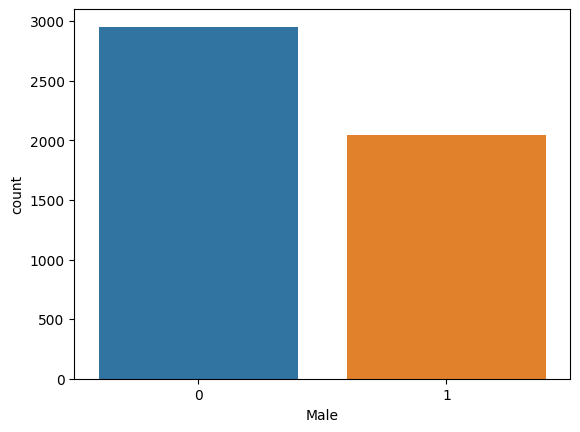

In [8]:
sns.countplot(x = new_data['Male']);

In [9]:
data.describe()

,Male
count,202599.000000
mean,-0.166491
std,0.986045
min,-1.000000
25%,-1.000000
50%,-1.000000
75%,1.000000
max,1.000000


In [10]:
new_data.describe()

,Male
count,5000.000000
mean,0.409400
std,0.491772
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [11]:
new_data_male = new_data[new_data['Male'] == 1]
new_data_female = new_data[new_data['Male'] == 0]
new_data_male = new_data_male.sample(frac = 1, random_state = 42)
new_data_female = new_data_female.sample(frac = 1, random_state = 42)

In [12]:
train_data = pd.concat([new_data_male[:1500], new_data_female[:1500]], axis = 0)
test_data = pd.concat([new_data_male[1500:], new_data_female[1500:]], axis = 0)
train_data.sort_index(inplace = True)
test_data.sort_index(inplace = True)
del new_data_male
del new_data_female

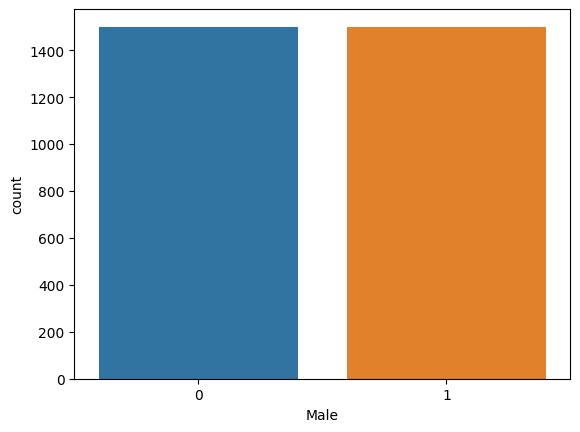

In [13]:
sns.countplot(x = train_data['Male']);

## Data Preprocessing:

In [14]:
train_data.iloc[0, 0]

'000051.jpg'

In [15]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform = None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        
        # Load Image and Convert to RGB:
#         try:
#             image = Image.open(image_path).convert('RGB')
#         except Exception as e:
#             print(f"Error loading image {image_path}: {e}")
#             return None, None
        image = Image.open(image_path).convert('RGB')
        gender = self.data.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(gender, dtype = torch.long)

In [16]:
# Define the Transformations:
transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(299),
        transforms.RandomRotation(45),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [17]:
train_set = GenderDataset(train_data, image_folder_path = os.path.join(data_path, "Images"), transform = transforms['train'])
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True, num_workers = 2)

In [18]:
test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform = transforms['test'])
test_loader = DataLoader(test_set, batch_size = 32, shuffle = False, num_workers = 2)

In [19]:
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_set), 'test': len(test_set)}

## Architecture:

In [20]:
from torchvision.models import Inception_V3_Weights

# Define the Model (GoogLeNet (Inception v3)) with updated weights parameter:
model = models.inception_v3(weights = Inception_V3_Weights.DEFAULT)  # Using updated weights parameter
num_ftrs = model.fc.in_features
# Adjust the final layer for Binary Classification:
model.fc = nn.Linear(num_ftrs, 1)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 151MB/s]  


In [21]:
# Define the Optimizer:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [22]:
# Define the Loss Function:
criterion = nn.BCEWithLogitsLoss()  # More stable than BCELoss for Binary Classification

In [23]:
# Move the Model to GPU if Available:
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.to('cuda')

## Modeling:

In [24]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu = torch.cuda.is_available(), num_epochs = 25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a Training and Validation Phase:
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train(True)  # Set model to Training Mode
            else:
                model.train(False)  # Set model to Evaluate Mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate Over Data:
            for data in dataloaders[phase]:
                # Get the Inputs:
                inputs, labels = data

                # Wrap them in Variable:
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Zero the Parameter Gradients:
                optimizer.zero_grad()

                # Forward:
                outputs = model(inputs)
                if phase == 'train':
                    outputs = outputs.logits

                outputs = outputs.squeeze()
                loss = criterion(outputs, labels.float())

                # Backward + Optimize Only if in Training Phase:
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Statistics:
                running_loss += loss.item() * inputs.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep Copy the Model:
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'/kaggle/working/model_best.pth')
                
            if phase == 'test':
                last_acc = epoch_acc
                last_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'/kaggle/working/model_last.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # Load Best Model Weights:
    model.load_state_dict(best_model_wts)
    return model

In [25]:
model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu, 25)

Epoch 0/24
----------
train Loss: 0.2687 Acc: 0.8880
test Loss: 0.1226 Acc: 0.9555

Epoch 1/24
----------
train Loss: 0.1213 Acc: 0.9540
test Loss: 0.1196 Acc: 0.9580

Epoch 2/24
----------
train Loss: 0.0799 Acc: 0.9697
test Loss: 0.1016 Acc: 0.9595

Epoch 3/24
----------
train Loss: 0.0694 Acc: 0.9777
test Loss: 0.0882 Acc: 0.9675

Epoch 4/24
----------
train Loss: 0.0491 Acc: 0.9823
test Loss: 0.0989 Acc: 0.9650

Epoch 5/24
----------
train Loss: 0.0384 Acc: 0.9867
test Loss: 0.0975 Acc: 0.9680

Epoch 6/24
----------
train Loss: 0.0373 Acc: 0.9863
test Loss: 0.1240 Acc: 0.9595

Epoch 7/24
----------
train Loss: 0.0390 Acc: 0.9880
test Loss: 0.1218 Acc: 0.9705

Epoch 8/24
----------
train Loss: 0.0223 Acc: 0.9923
test Loss: 0.0960 Acc: 0.9695

Epoch 9/24
----------
train Loss: 0.0138 Acc: 0.9960
test Loss: 0.1096 Acc: 0.9695

Epoch 10/24
----------
train Loss: 0.0180 Acc: 0.9943
test Loss: 0.0872 Acc: 0.9740

Epoch 11/24
----------
train Loss: 0.0179 Acc: 0.9917
test Loss: 0.1142 Acc

## Evaluation:

In [26]:
# For if Loading Weights onto a Model, otherwise keep commented:
model.load_state_dict(torch.load('/kaggle/working/model_best.pth')['model'])
if torch.cuda.is_available():
  model = model.to("cuda")

In [27]:
y_true = torch.empty((0)).cuda()
y_pred = torch.empty((0)).cuda()
for data in dataloaders['test']: 
      inputs, labels = data
      #print(labels)
      if torch.cuda.is_available():
          inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
      else:
          inputs, labels = Variable(inputs), Variable(labels)
      #print(labels)
      #_, lab = torch.max(labels.data, 1)
      outputs = model(inputs)
      #print(outputs)
      preds = (torch.sigmoid(outputs).squeeze() > 0.5).float()
      y_true = torch.cat((y_true, labels.data), -1)
      y_pred = torch.cat((y_pred, preds), -1)

In [28]:
y_true_np = y_true.detach().cpu().numpy()
y_pred_np = y_pred.detach().cpu().numpy()
print(classification_report(y_true_np, y_pred_np, digits = 4))

              precision    recall  f1-score   support

         0.0     0.9909    0.9745    0.9827      1453
         1.0     0.9352    0.9762    0.9553       547

    accuracy                         0.9750      2000
   macro avg     0.9631    0.9754    0.9690      2000
weighted avg     0.9757    0.9750    0.9752      2000



## Validation:

In [64]:
model = models.inception_v3(aux_logits = False, pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

In [65]:
# Load State Dict dari File:
state_dict = torch.load('/kaggle/input/celeba-gender-classification-best-model/pytorch/facerecognition/2/model_best_Inception 3 Epoch 25 Weights BCE- Bella on Kaggle/model_best_Inception 3 Epoch 25 Weights BCE- Bella on Kaggle.pth')['model']

In [66]:
# Hapus Kunci yang Tidak Sesuai dari State Dict (jika diperlukan):
keys_to_remove = ["AuxLogits.conv0.conv.weight", "AuxLogits.conv0.bn.weight", "AuxLogits.conv0.bn.bias", 
                  "AuxLogits.conv0.bn.running_mean", "AuxLogits.conv0.bn.running_var", "AuxLogits.conv0.bn.num_batches_tracked", 
                  "AuxLogits.conv1.conv.weight", "AuxLogits.conv1.bn.weight", "AuxLogits.conv1.bn.bias", 
                  "AuxLogits.conv1.bn.running_mean", "AuxLogits.conv1.bn.running_var", "AuxLogits.conv1.bn.num_batches_tracked", 
                  "AuxLogits.fc.weight", "AuxLogits.fc.bias"]
for key in keys_to_remove:
    if key in state_dict:
        del state_dict[key]

In [67]:
# Load State Dict ke Model:
model.load_state_dict(state_dict);

In [68]:
# Pindahkan Model ke GPU jika Tersedia:
if torch.cuda.is_available():
    model = model.to("cuda")

In [69]:
# Definisikan Transformasi untuk Validasi:
from torchvision import transforms as T

val_transforms = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [70]:
# Daftar gambar validasi
val_images_list = os.listdir('/kaggle/input/celeba-face-recognition/validation_images/validation_images')
val_images_list.sort()

In [71]:
val_images_list

['female_1.jpeg',
 'female_2.jpeg',
 'female_3.jpeg',
 'female_4.jpeg',
 'female_5.jpeg',
 'male_1.jpg',
 'male_2.jpeg',
 'male_3.jpeg',
 'male_4.jpeg',
 'male_5.jpeg']

In [72]:
# Prediksi Gambar Validasi:

inf_time_start = time.time()
val_pred = torch.empty((0)).cuda() if torch.cuda.is_available() else torch.empty((0))
for i in val_images_list:
    image_path = os.path.join('/kaggle/input/celeba-face-recognition/validation_images/validation_images', i)
    image = Image.open(image_path).convert('RGB')
    inputs = val_transforms(image)
    inputs = inputs.unsqueeze(0)
    if torch.cuda.is_available():
        inputs = inputs.cuda()

    with torch.no_grad():  # Nonaktifkan Gradient Calculation untuk Menghemat Memori
        outputs = model(inputs)
    
    preds = (torch.sigmoid(outputs).squeeze() > 0.5).float()
    if torch.cuda.is_available():
        val_pred = torch.cat((val_pred, preds.reshape(1).cuda()), -1)
    else:
        val_pred = torch.cat((val_pred, preds.reshape(1)), -1)

print('Prediction Time for Each Image is {} ms'.format(1000 * (time.time() - inf_time_start) / len(val_images_list)))

Prediction Time for Each Image is 33.482909202575684 ms


In [73]:
val_pred

tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 0.], device='cuda:0')